In [1]:
# Code to test 2D correlation method of finding striped satellite artifacts

In [1]:
pip install opencv-python-headless

  Using cached opencv_python_headless-4.5.1.48-cp38-cp38-manylinux2014_x86_64.whl (37.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install keras

  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

  Using cached tensorflow-2.4.1-cp38-cp38-manylinux2010_x86_64.whl (394.4 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached absl_py-0.12.0-py3-none-any.whl (129 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached tensorflow_estimator-2.4.0-py2.py3-none-any.whl (462 kB)
  Using cached h5py-2.10.0-cp38-cp38-manylinux1_x86_64.whl (2.9 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached tensorboard-2.4.1-py3-none-any.whl (10.6 MB)
  Using cached protobuf-3.15.6-cp38-cp38-manylinux1_x86_64.whl (1.0 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached numpy-1.19.5-cp38-cp38-manylinux2010_x86_64.whl (14.9 MB)
  Using cached grpcio-1.32.0-cp38-cp38-manylinux2014_x86_64.whl (3.8 MB)
  Using cached Werkzeug-1.0.1-py2.py

In [4]:
pip install https://github.com/chunglabmit/pystripe/archive/master.zip

  Using cached https://github.com/chunglabmit/pystripe/archive/master.zip
  Using cached pathlib2-2.3.5-py2.py3-none-any.whl (18 kB)
  Using cached dcimg-0.6.0.post1-py3-none-any.whl (8.3 kB)
  Created wheel for pystripe: filename=pystripe-0.2.0-py3-none-any.whl size=15739 sha256=9600c89be2247a373165dd9efecdc903cda9d3440e4f65065f225332d50fc282
  Stored in directory: /tmp/pip-ephem-wheel-cache-wvvx4c72/wheels/7e/1b/9b/47886f40cec8c1e78cb0e9f8cdf51b3d187f82ef5554c22de8
Successfully built pystripe
Note: you may need to restart the kernel to use updated packages.


In [28]:
cd ..

/home/jovyan


In [29]:
from dask.distributed import Client
from dask.diagnostics import ProgressBar
import dask
import dask.delayed
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd

import hvplot.xarray
from matplotlib import pyplot as plt
from rasterio import RasterioIOError
from tqdm.autonotebook import tqdm
%matplotlib inline
import sklearn.linear_model
import skimage.morphology
import skimage.segmentation
#import richdem as rd
import scipy.ndimage
import dask
import math
import scipy.sparse
import shapefile
import shapely
import rioxarray
from shapely.geometry import mapping
import cv2
import gcsfs
import json

In [31]:
cd 

/home/jovyan


In [32]:
import HydrologyFunctions as hf

from Destriping_functions import Lloyd_destripe, Guan_destripe, Rogass_destripe,\
Pande_Chhetri_destripe, Pystripe_destripe, RMSE_metric, SSIM_metric, PSNR_metric
from Oblique_destriping_functions import striping_angle, grad_image,\
super_Gauss_filter, refinement_destriping

In [33]:
# Destriping functions: striped image in, destriped image out
# assumes stripes aligned vertically in image

import numpy as np

# Guan et al libraries
from keras.models import Model
from keras.layers import  Input, Conv2D, Activation, Add

# Pystripe library
import pystripe

# Pande-Chhetri libraries
import pywt

# Rogass et al. libraries
from scipy import signal


#%% Our technique (oriented super-Gaussian filter)

import cv2
# calculate approximate image gradient (for gradient test)
def grad_image(array):
    return (cv2.Laplacian(np.asarray(array),cv2.CV_32FC1))

# Rotated super-Gaussian for the filter
def SGaussian_rotated(x_mesh,y_mesh,x0,y0,wx,wy,px,py,theta):
    theta = np.deg2rad(theta)
  
    x_mesh_rot = x_mesh*np.cos(theta)-y_mesh*np.sin(theta)
    y_mesh_rot = x_mesh*np.sin(theta)+y_mesh*np.cos(theta)
    
    y_mesh_rot = np.fft.fftshift(y_mesh_rot,1)   
    
    SG = np.exp(-abs((x_mesh_rot-x0)/wx)**px-abs((y_mesh_rot-y0)/wy)**py)
   
    SG = 1-SG
    return SG


def super_Gauss_filter(input_img,sg_width,sg_pow):
    mask = np.copy(input_img) # copy avoids writing issues

    Ly,Lx = np.shape(input_img)
    x = np.linspace(-Lx/2-1, Lx/2,Lx)
    y = np.linspace(-Ly/2-1, Ly/2,Ly)

    x_mesh, y_mesh = np.meshgrid(x, y)


    # generate filter and apply to Fourier transform
    #recall SG(x_mesh,y_mesh,offset in x, offset in y, width across Fourier domain band,
    # width along Fourier domain band, super-Gaussian power across band, angle in Fourier domain)
    SG = SGaussian_rotated(x_mesh,y_mesh,0,0,Lx/200,sg_width,2,sg_pow,90) # 90 degree angle for verical stripes

    # apply filter in Fourier domain
    FT = np.fft.fft2(mask)
    FT = np.fft.fftshift(FT)
    FT_filt = FT*(SG) 
    FT_filt = np.fft.ifftshift(FT_filt)
    img_filt = np.fft.ifft2(FT_filt)
    img_filt = abs(img_filt)
    
    # adjust filtered pixels to account for "power" loss caused by filter
    # as per Parseval's theorem
    scale_fac = np.sum(mask)/np.sum(img_filt)
    img_filt = img_filt *scale_fac

    return img_filt

# Using estimate of stripes provided after filtering, refine the estimate
# and destripe with that
def refinement_destriping(striped_image,destriped_image):
    
    stripe_estimate = striped_image - destriped_image
    Ly,Lx = np.shape(stripe_estimate)
    
    output_vec = np.zeros(Lx)
    for ii in range(0,Lx):
        column = stripe_estimate[:,ii]
        column = column[striped_image[:,ii]>0]
        
        # column length non-zero take median, else do nothing to destriping image
        if np.sum(np.abs(column))>0:
            output_vec[ii] = np.median(column)
        else:
           output_vec[ii] = 0
           
    # exclude outliers
    output_vec[(np.abs(output_vec)-np.mean(output_vec))>4*np.std(output_vec)]=0 
        
    w1 = np.ones(Ly)
    stripe_matrix = np.outer(w1,output_vec)
    refined_destriped_image = striped_image-stripe_matrix
    
    return refined_destriped_image

def Lloyd_destripe(array,width,power):
    Ly,Lx = np.shape(array)
    filtered_array = super_Gauss_filter(array,width,power)
    
    #gradient test
    if np.amax(grad_image(np.asarray(array/np.mean(array),dtype= np.float32)))>0.1:
    
        # refine guess of stripe contribution to image
        destriped_array = refinement_destriping(array,filtered_array)
        return destriped_array
    else:
        return filtered_array
     

    


#%% Guan et al. (needs weight file)

# tests indicate that image needs to be min/max normalised for best performance
def minmax_norm(array,min_val,max_val):
    return (array-min_val)/(max_val-min_val)

def undo_norm(array,min_val,max_val):
    return array*(max_val-min_val)+min_val

def SNRDWNN():

    inpt = Input(shape=(None,None,4))
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same' ,kernel_initializer=init,name='Conv-1')(inpt)
    x = Activation('relu')(x)
    for i in range(8):
        x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same' ,kernel_initializer=init)(x)
        x = Activation('relu')(x)
    residual = Conv2D(filters=4, kernel_size=(3,3), strides=(1,1), padding='same' ,kernel_initializer=init, name = 'residual')(x)
    res = Add(name = 'res')([inpt,residual])
    model = Model(inputs=inpt, 
                  outputs=[res,residual],
                  name = 'DWSRN'
                  )

    return model

L2 = None
init = 'he_normal'
checkpoint_file = 'REMAWaterRouting/Functions/weights'
WEIGHT_PATH = './'+checkpoint_file+'/weight.hdf5'
model =  SNRDWNN()
model.load_weights(WEIGHT_PATH)


def Guan_destripe(input_array):
                    
    array = minmax_norm(input_array,np.amin(input_array),np.amax(input_array))
    # Discrete Wavelet Transform
    LLY,(LHY,HLY,HHY) = pywt.dwt2(array, 'haar')
    Y = np.stack((LLY,LHY,HLY,HHY),axis=2)
    # predict
    x_test = np.expand_dims(Y,axis=0)
    y_pred,noise = model.predict(x_test)

    coeffs_pred = y_pred[0,:,:,0],(LHY,y_pred[0,:,:,2],HHY)

    img_out = pywt.idwt2(coeffs_pred, 'haar')

    output_array = np.clip(img_out, 0, 1) # necessary?
    
    output_array = undo_norm(output_array,np.amin(input_array),np.amax(input_array))
    return output_array

#%% Rogass et al.
    # Rogass et al.

def Rogass_destripe(input_array):
    
    rad_gradx = np.gradient(input_array,axis=1) # gradient in x (horizontal) direction

    # "boxcar filter of length 3: middle column entries have value 1/3 (for normalisation)
    fil2 = np.zeros([3,3])
    fil2[1] = 1/3
    fil2 = np.transpose(fil2)

    # gradient in x
    rad_gradx_sup = signal.convolve2d(rad_gradx,fil2,boundary='fill', mode='same')

    LHS = np.median(rad_gradx_sup,axis=0) #median of rows. 0 or 1?

    w1 = np.ones(np.shape(input_array)[0]) # "a row vector of width equal to the number of rows and valued 1" 

    # integrand of equation (6) in Rogass et al.
    integrand = np.outer(w1,LHS) 
    # not sure of the point in integrating the integrand over x, so ignore here

    #gradient calculation causes one pixel shift, roll ==matlab circshift, corrected here
    stripe_guess_1 = np.roll(integrand,1,1) # equation (6) ignoring integral


    # recommended post-processing steps

    # equation (7)
    stripe_guess_2 = stripe_guess_1-np.mean(stripe_guess_1)
    stripe_guess_2 = stripe_guess_2 - np.mean(input_array)\
                    + np.mean(input_array-stripe_guess_1+np.mean(stripe_guess_1))
    
    # skip equation (8) as no stray light or long wave gradients in this problem
    
    output_array = input_array - stripe_guess_2 # destriped image
    return output_array

#%% Pande-Chhetri

def frequency_domain_filtering(HL,k):
    
    # Initialize the filter HLf
    HLf = np.zeros(HL.shape)
    
    # Determine the number of columns
    cols = HL.shape[1]
    
    for i in range(cols):
        # Extract the column x
        x = HL[:,i]
        
        # Compute the fft of x
        Xf = np.fft.fft(x)
        
        # Compute the mean of the vector
        mu_x = np.mean(x)
        
        # Compute the standard deviation of the vector
        sig = np.std(x)
        
        # Extract the sub-vector y
        y = x[np.abs(x - mu_x) < k*sig]
        
        # Compute the mean of the vector
        mu_y = np.mean(y)
        
        # Compute the fft of y
        Yf = np.fft.fft(y)
        
        # Extract the original dc component
        Forig = Yf[0]
        
        # Derive the normalized dc component
        Fnorm = Forig * (mu_x - mu_y)/mu_x
        
        # Replace the dc component of Xf
        Xf[0] = Fnorm
        
        # Compute the invese fft
        HLf[:,i] = np.real(np.fft.ifft(Xf))

    return HLf

def Pande_Chhetri_destripe(img_in,L,k):
# Compute the multiscale wavelet decomposition db4 level 4 as per paper
    coeffs = pywt.wavedec2(img_in, wavelet='db4', level=int(L))

    # Filter the stripes in the frequency domain
    coeffs_filt = np.copy(coeffs)
    for ii in range(0,int(L)):
        coeffs_filt[ii+1][1][:] = frequency_domain_filtering(coeffs[ii+1][1],k)

    img_tilde = pywt.waverec2(tuple(coeffs_filt), 'db4')
    return img_tilde
    
#%% Pystripe
# awkwardly needs horizontal stripes and an expanded dynamic range to 
# work well
def Pystripe_destripe(array, sigma_1,sigma_2,level_):
    factor = 2**12
    striped_array = np.transpose(array)
    mod_fac = np.amax(striped_array)/factor
    striped_array = striped_array/mod_fac
    destriped_array = pystripe.filter_streaks(striped_array, sigma=[sigma_1, sigma_2],\
                                              level=level_, wavelet='db2')
    #undo modifications
    destriped_array =np.transpose(destriped_array*mod_fac)
    
    return destriped_array

#%% define some standard performance metrics
    
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def RMSE_metric(img1,img2):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    return(np.sqrt(np.mean( (img1 - img2) ** 2 )))
    
def SSIM_metric(img1,img2):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    pixel_max = np.max(np.maximum(img1, img2))
    pixel_min = np.min(np.minimum(img1, img2))
    pixel_diff = pixel_max-pixel_min

    return(ssim(img1,img2,data_range = pixel_diff))

def PSNR_metric(img1,img2):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    pixel_max = np.max(np.maximum(img1, img2))
    pixel_min = np.min(np.minimum(img1, img2))
    pixel_diff = pixel_max-pixel_min
    return(psnr(img1,img2,data_range = pixel_diff))

In [34]:
import math
import numpy as np
import sklearn.linear_model
import skimage.morphology
import skimage.segmentation
import scipy.ndimage
import dask
import geopandas as gpd
import shapely
from rasterio import RasterioIOError
from tqdm.autonotebook import tqdm
import xarray as xr
import os

#for drainage_network
import networkx as nx


#read in the shapefiles of ice shelf grounding lines
IS = gpd.read_file('data/IceShelf_Antarctica_v02.shp') 
#read in the REMA tile index
REMA_index = gpd.read_file('data/REMA_Tile_Index_Rel1_1.shp')

def download_REMA(shelf):
    #bounding box of ice shelf
    SelectedIceShelf = IS[IS.NAME==shelf]
    [minx,miny,maxx,maxy]= SelectedIceShelf.bounds.values.tolist()[0]

    bbox = shapely.geometry.asPolygon([[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy],[minx,miny]])

    IS_intersection = np.argwhere(REMA_index.overlaps(bbox).tolist())

    IS_tiles = REMA_index.tile[IS_intersection.flatten()]

    row=np.zeros((len(IS_tiles),1))
    col=np.zeros((len(IS_tiles),1))
    for i in np.arange(0,len(IS_tiles)):
        [row[i],col[i]] = str.split(IS_tiles.to_list()[i],sep='_')

    row = np.int_(row)
    col = np.int_(col)

    #Load the REMA tiles lazily
    uri_fmt = 'https://storage.googleapis.com/pangeo-pgc/8m/{i_idx:02d}_{j_idx:02d}/{i_idx:02d}_{j_idx:02d}_8m_dem_COG_LZW.tif'

    chunksize = 8 * 512
    rows = []
    for i in tqdm(range(row.max()-1, row.min()-1, -1)): #this tile range is Amery Ice Shelf
        cols = []
        for j in range(col.min(),col.max()):
            uri = uri_fmt.format(i_idx=i, j_idx=j)
            try:
                dset = xr.open_rasterio(uri, chunks=chunksize)
                dset_masked = dset.where(dset > 0.0)
                cols.append(dset_masked)
                #print(uri)
            except RasterioIOError:
                pass
        rows.append(cols)

    dsets_rows = [xr.concat(row, 'x') for row in rows]
    ds = xr.concat(dsets_rows, 'y', )
    ds_array = ds.squeeze()
    coarsed_masked_array = ds_array.coarsen(x=100,y=100).mean()
    cellsize = ds_array.res[0]
    sample = coarsed_masked_array.chunk((cellsize*250,cellsize*250))
    return(sample)

def flag_nans(dem):
    log_nans = np.isnan(dem);
         # handle NaNs

    if np.any(log_nans):
        flag_nans = 1;
    else:
        flag_nans = 0;
    return flag_nans
    
def identifyflats(dem):
    flats=np.zeros(dem.size)

    if flag_nans==True:
        dem = dask.array.nan_to_num(dem, nan=-np.inf) 
    else:
        dem = dem


    nhood = np.ones((3,3))
    # identify flats
    # flats: logical matrix with true where cells don't have lower neighbors

    if len(dem)>1:
        flats = skimage.morphology.erosion(image=dem,selem=nhood) == dem;

        #remove flats at the border
        flats[0:-1,[1, -1]]  = 0;
        flats[[0 -1],0:-1]  = 0;

        flats = skimage.segmentation.clear_border(flats, buffer_size=0)

       # if flag_nans==1:
        #    # remove flat pixels bordering to nans
         #   flats[skimage.morphology.dilation(image=log_nans,selem = nhood)] = 0
    return flats


def identifysills(dem,flats):
    # identify sills
    sills=np.zeros(dem.size)
    nhood = np.ones((3,3))

    log_nans = np.isnan(dem);

    # find sills and set marker
    if len(dem)>1:
        Imr = -np.inf * np.ones(flats.shape);
        Imr[flats.astype(int)] = 0;
        maskeddem = np.multiply(dem,flats)
        Imr = Imr + maskeddem;
        Imr = (skimage.morphology.dilation(image=Imr,selem=nhood) == dem) & np.logical_not(flats);

        if flag_nans==True:
               Imr[log_nans] = 0;

        sills = Imr
    return sills
    
def identifyinteriorbasins(dem):
    log_nans = np.isnan(dem);

    # identify interior basins
    interiorbasins=np.zeros(dem.size)

    if len(dem)>1:
        interiorbasins = skimage.morphology.local_minima(dem);

    if flag_nans==1:
        interiorbasins = np.bitwise_or(interiorbasins,log_nans);
        if interiorbasins.shape[0]>0:
            interiorbasins = skimage.segmentation.clear_border(interiorbasins, buffer_size=0);
        interiorbasins[log_nans] = 0;
    else:
        if interiorbasins.shape[0]>0:
            interiorbasins = skimage.segmentation.clear_border(interiorbasins);

    return interiorbasins
    
import heapq
from imageio import imread


DIR_STRINGS = ["left", "down", "right", "up"]
DIRS = ((-1, 0), (0, -1), (1, 0), (0, 1))

def map_image_to_costs(D, PreSillPixel):
    """
    Read image data and convert it to a marginal cost function,
    a 2D array containing costs for moving through each pixel.
    This cost field forms the input for the weighted distance transform
    zero costs denote exits, infinite costs denote fully impenetrable obstacles.
    In this example, we follow Mercurial standards: obstacles are in black, exits in green,
    accessible space is in white, less accessible space has less white.
    Adapt to your own needs.
    :param image: String of image file or open file descriptor of image
    :return: 2D array representing the cost field
    """
    
    G = (D-np.min(D))/(np.max(D)-np.min(D))**-1
    if len(PreSillPixel)>0:
        for pair in PreSillPixel:
            PSPx = int(pair[0])
            PSPy = int(pair[1])

        #R = abs(D)*255/np.max(abs(D))

        G[PSPx,PSPy] = 1
        #B = abs(D)*255/np.max(abs(D)
    
    data = G*256
    # Exits are present in all green enough places ("G >> R and G")
    exits = np.where(data >= 255 )
    # Obstacles are in black (so at least G and B must be zero)
    obstacles = np.where(data < 1)
    # Convert image to greyscale
    grey_scales = data
    # Boolean index array for places without exits and obstacles
    space = np.ones(grey_scales.shape, dtype=np.bool)
    space[obstacles] = False
    space[exits] = False
    # Cost field: Inversely proportional to greyscale values
    cost_field = np.empty(data.shape)
    cost_field[obstacles] = np.inf
    cost_field[exits] = 0
    cost_field[space] = 1. / (grey_scales[space])
    return cost_field

def _wdt_python(cost_field):
    """
    See `get_weighted_distance_transform`
    :param cost_field: 2D array
    :return: Weighted distance transform array with same shape as `cost_field`
    """
    nx, ny = cost_field.shape
    # Cost for moving along horizontal lines
    costs_x = np.ones([nx + 1, ny], order='F') * np.inf
    costs_x[1:-1, :] = (cost_field[1:, :] + cost_field[:-1, :]) / 2
    # Cost for moving along vertical lines
    costs_y = np.ones([nx, ny + 1], order='F') * np.inf
    costs_y[:, 1:-1] = (cost_field[:, 1:] + cost_field[:, :-1]) / 2

    # Initialize locations (known/unknown/exit/obstacle)
    weighted_distance_transform = np.ones_like(cost_field, order='F') * np.inf
    exit_locs = np.where(cost_field == 0)
    obstacle_locs = np.where(cost_field == np.inf)
    weighted_distance_transform[exit_locs] = 0

    # Initialize Cell structures
    all_cells = {(i, j) for i in range(nx) for j in range(ny)}
    known_cells = {cell for cell in zip(exit_locs[0], exit_locs[1])}
    unknown_cells = all_cells - known_cells - {cell for cell in zip(obstacle_locs[0], obstacle_locs[1])}
    new_candidate_cells = set()
    for cell in known_cells:
        new_candidate_cells |= _get_new_candidate_cells(cell, unknown_cells)
    cand_heap = [(np.inf, cell) for cell in new_candidate_cells]
    # Loop until all unknown cells have a distance value
    if len(cand_heap)>0:
        while True:
            # by repeatedly looping over the new candidate cells
            for cell in new_candidate_cells:
                # Compute a distance for each cell based on its neighbour cells
                distance = _propagate_distance(cell, [costs_x, costs_y], weighted_distance_transform)
                # Store this value in the heap (for fast lookup)
                # Don't check whether we have the distance already in the heap; check on outcome
                heapq.heappush(cand_heap, (distance, cell))
            # See if the heap contains a good value and if so, add it to the field. If not, finish.
            # Since we can store multiple distance values for one cell, we might need to pop a couple of times
            while True:
                min_distance, best_cell = heapq.heappop(cand_heap)
                if weighted_distance_transform[best_cell] == np.inf:
                    # Got a good one: no assigned distance in wdt yet
                    break
                elif min_distance == np.inf:  # No more finite values; done
                    return weighted_distance_transform
            # Good value found, add to the wdt and
            weighted_distance_transform[best_cell] = min_distance
            unknown_cells.remove(best_cell)
            new_candidate_cells = _get_new_candidate_cells(best_cell, unknown_cells)
    else:
        weighted_distance_transform = scipy.ndimage.distance_transform_edt(cost_field)+1
        return weighted_distance_transform
    """
    Checks whether an index exists an array
    :param index: 2D index tuple
    :return: true if lower than tuple, false otherwise
    """
    return (0 <= index[0] < nx) and (0 <= index[1] < ny)
def _exists(index, nx, ny):
    """
    Checks whether an index exists an array
    :param index: 2D index tuple
    :return: true if lower than tuple, false otherwise
    """
    return (0 <= index[0] < nx) and (0 <= index[1] < ny)


def _get_new_candidate_cells(cell, unknown_cells):
    """
    Compute the new candidate cells (cells for which we have no definite distance value yet
    For more information on the algorithm: check fast marching method
    :param cell: tuple of index; a new cell that has been added to the distance field
    :param unknown_cells: set of tuples; all cells still unknown
    :return: Set of new candidate cells for which to compute the distance
    """
    new_candidate_cells = set()
    for direction in DIRS:
        nb_cell = (cell[0] + direction[0], cell[1] + direction[1])
        if nb_cell in unknown_cells:
            new_candidate_cells.add(nb_cell)
    return new_candidate_cells


def _propagate_distance(cell, costs, wdt_field):
    import math
    """
    Compute the weighted distance in a cell using costs and distances in other cells
    :param cell: tuple, index of a candidate cell
    :param costs: list of cost arrays in X and Y direction
    :param wdt_field: the weighted distance transform field up until now
    :return: a approximate distance based on the neighbour cells
    """
    nx, ny = wdt_field.shape
    # Find the minimal directions along a grid cell.
    # Assume left and below are best, then overwrite with right and up if they are better
    adjacent_distances = np.ones(4) * np.inf
    pots_from_axis = [0, 0]  # [x direction, y direction]
    costs_from_axis = [np.inf, np.inf]  #
    for i, dir_s in enumerate(DIR_STRINGS):
        # Direction for which we check the cost
        normal = DIRS[i]
        nb_cell = (cell[0] + normal[0], cell[1] + normal[1])
        if not _exists(nb_cell, nx, ny):
            continue
        pot = wdt_field[nb_cell]
        # distance in that neighbour field
        if dir_s == 'left':
            face_index = (nb_cell[0] + 1, nb_cell[1])
        elif dir_s == 'down':
            face_index = (nb_cell[0], nb_cell[1] + 1)
        else:
            face_index = nb_cell
        # Left/right is x, up/down is y
        cost = costs[i % 2][face_index]
        # Proposed cost along this direction
        adjacent_distances[i] = pot + cost
        # If it is cheaper to go from the opposite direction
        if adjacent_distances[i] < adjacent_distances[(i + 2) % 4]:
            pots_from_axis[i % 2] = pot
            costs_from_axis[i % 2] = cost
        hor_pot, ver_pot = pots_from_axis
        hor_cost, ver_cost = costs_from_axis
        # Coefficients of quadratic equation (upwind discretization)
    a = 1. / hor_cost ** 2 + 1. / ver_cost ** 2
    b = -2 * (hor_pot / hor_cost ** 2 + ver_pot / ver_cost ** 2)
    c = (hor_pot / hor_cost) ** 2 + (ver_pot / ver_cost) ** 2 - 1

    D = b ** 2 - 4 * a * c
    # Largest root represents upwind approximation
    x_high = (2 * c) / (-b - math.sqrt(D+0.001)) #edited to prevent divide by zero errors
    return x_high


def drainagebasins(Z,flats,sills,interiorbasins, cellsize):  
    
    Z_ravel = np.ravel(Z)
    nrc = Z_ravel.shape[0]

    Iobj  = flats
    SILLS = sills
    IntBasin = interiorbasins

    # Here we choose the distance transform from outside the lakes to the inside and take the locations as sills where the distance is maximum.
    DD = scipy.ndimage.distance_transform_edt(IntBasin);
    MaxIntIX = [0,0] #added to prevent MaxIntIX does not exist errors
    IntBasin_labels = skimage.measure.label(IntBasin)
    for r in np.arange(0,np.max(IntBasin_labels)+1):
        PixelIdxList = np.argwhere(IntBasin_labels==r)
        ixm = np.argmax(DD[IntBasin_labels==r]);
        MaxIntIX = PixelIdxList[ixm];

        Iobj[PixelIdxList[0][0],PixelIdxList[0][1]] = 0;
        SILLS[PixelIdxList[0][0],PixelIdxList[0][1]] = 1;
    ixm = MaxIntIX;
    Iobj[ixm[0],ixm[1]] = 0;
    SILLS[ixm[0],ixm[1]] = 1;

    # establish the connectivity between sills and flats
    #dem = ZintoDB;
    whereSILLS = np.argwhere(SILLS);
    rows=[]
    cols=[]
    for rowcol in whereSILLS:    
        [row,col] = rowcol
        rows = np.append(rows,row)
        cols = np.append(cols,col)

    IXsill    = [rows,cols];
    rowadd = [-1, -1, 0, 1, 1,  1,  0, -1];
    coladd = [ 0,  1, 1, 1, 0, -1, -1, -1];
    PreSillPixel = [0]
    for r  in np.arange(0,8):
        rowp = rows + rowadd[r];
        colp = cols + coladd[r];

        ValidRowColPair1 = np.bitwise_and(rowp>0, colp>0)
        ValidRowColPair2 = np.bitwise_and(rowp<Z.shape[0], colp<Z.shape[1])
        ValidRowColPair  = np.bitwise_and(ValidRowColPair1, ValidRowColPair2) 
        whereValidRowColPair = np.where(ValidRowColPair)

        IXPreSill = [rowp[whereValidRowColPair],colp[whereValidRowColPair]];
        I1 = np.ravel_multi_index([np.int_(rows[whereValidRowColPair]), np.int_(cols[whereValidRowColPair])],Z.shape)
        I2 = np.ravel_multi_index([np.int_(IXPreSill[0]),np.int_(IXPreSill[1])],Z.shape)
        I3 = np.ravel_multi_index([np.int_(IXPreSill[0]),np.int_(IXPreSill[1])], Z.shape)
        PreSillPixelCondition = (np.argwhere(np.bitwise_and((Z_ravel[I1] == 
                    Z_ravel[I2]),
                   Iobj.ravel()[I3])))        
        if np.count_nonzero(PreSillPixelCondition)>0:
               for i in  np.arange(0,len(PreSillPixelCondition)):
                    PreSillPixelAddition = ([IXPreSill[0][PreSillPixelCondition[i]],IXPreSill[1][PreSillPixelCondition[i]]])
                    PreSillPixel.append(PreSillPixelAddition)
        else:
            continue
    PreSillPixel.pop(0);

    #Iobj  = np.bitwise_not(Iobj)    
    D = scipy.ndimage.distance_transform_edt(Iobj)
    masked = np.inf * np.ones(Z.shape,D.dtype); 
    masked[Iobj] = 0;
    D[np.bitwise_not(Iobj)]=np.inf
    D = ((skimage.morphology.reconstruction(seed = D+1,mask=masked,method='erosion'))- D) *cellsize
    D = np.nan_to_num(D)  

    D[~Iobj] = 1
    #D = D**-1
    cost_field  = map_image_to_costs(D**-1,PreSillPixel)
    D = _wdt_python(cost_field) +1
    D[~Iobj] = -np.inf

    D = np.reshape(D.data,[1,D.shape[0]*D.shape[1]])
    IXSortedFlats = np.argsort(D.ravel(),kind='mergesort');
    #IXSortedFlats = IXSortedFlats[::-1]
    #del D

    ndx = np.arange(np.uint32(0),np.uint32(nrc));
    ndx = ndx[IXSortedFlats];

    ndx = np.arange(np.uint32(0),np.uint32(nrc));
    ndx = ndx[IXSortedFlats];
    del IXSortedFlats

    ix = np.argsort(Z_ravel[ndx]);
    ix = ix[::-1]
    ix = ndx[ix]
    #del ndx

    # a fast solution that has quite much memory overhead...
    pp = np.zeros(Z_ravel.shape,dtype=np.int32);
    IX = np.arange(np.int32(0),np.int32(Z_ravel.shape));
    pp[ix] = IX;
    pp = pp.reshape(Z.shape)

    # cardinal neighbors
    IXC1 = skimage.morphology.dilation(pp, skimage.morphology.selem.diamond(1))
    IXC1 = IXC1.ravel()
    xxx1 = IXC1;
    IX   = IXC1[ix];
    IXC1 = ix[IX];

    G1   = (Z_ravel[ix]-Z_ravel[IXC1])/(cellsize);
    I4 = (np.argwhere(ix == IXC1)).ravel()

    I4 = list(I4)
    I4_test = np.zeros(G1.shape)
    I4_test[I4] = -np.inf
    G1 = G1 + I4_test;
    #G1[ix == IXC1] = -np.inf;

     # diagonal neighbors
    kernel = np.array([[1,0,1],[0,1,0],[1,0,1]])
    IXC2 = skimage.morphology.dilation(pp,kernel);
    IXC2 = IXC2.ravel()
    xxx2 = IXC2;
    IX   = IXC2[ix];
    IXC2 = ix[IX];
    G2   = (Z_ravel[ix]-Z_ravel[IXC2])/np.linalg.norm([cellsize,cellsize]);


    # choose the steeper one
    #I  = np.bitwise_and(G1<=G2, xxx2[ix]>xxx1[ix]);
    I  = dask.array.bitwise_and(dask.array.less_equal(G1,G2),xxx2[ix]>xxx1[ix])
    ixc = IXC1;
    ixc[I] = IXC2[I];

    I = ixc == ix;
    ix = ix[np.bitwise_not(I)];
    ixc = ixc[np.bitwise_not(I)];
    
     # remove nans
    I = np.isnan(Z_ravel);
    ixc = ixc[~I[ix]];
    ix = ix[~I[ix]];
    
    ix = np.int_(ix[~np.isnan(ix)])
    ixc = np.int_(ixc[~np.isnan(ixc)])
    
    DBcounter = 0;
    D = np.zeros(Z_ravel.shape[0],dtype=np.int32);
    outlets=np.zeros((len(ix),1))
    for r in np.arange(len(ix)-1,1,-1):
        if D[ixc[r]] == 0:
            DBcounter = DBcounter+1;
            D[ixc[r]] = DBcounter;
            outlets[DBcounter] = ixc[r];

        D[ix[r]] = D[ixc[r]];

    D = D.reshape(Z.shape)
    return D

def accumulation(Z,flats,sills,interiorbasins, cellsize):  
    
    #[Iobj,SILLS,IntBasin] = identifyflats(Z);
    Z = Z.data
    Z_ravel = np.ravel(Z)
    nrc = Z_ravel.shape[0]
    
    Iobj  = flats
    SILLS = sills
    IntBasin = interiorbasins

    # Here we choose the distance transform from outside the lakes to the inside and take the locations as sills where the distance is maximum.
    DD = scipy.ndimage.distance_transform_edt(np.bitwise_not(IntBasin));
    MaxIntIX = [0,0] #added to prevent MaxIntIX does not exist errors
    IntBasin_labels = skimage.measure.label(IntBasin)
    for r in np.arange(1,np.max(IntBasin_labels)):
        PixelIdxList = np.argwhere(IntBasin_labels==r)
        ixm = np.argmax(DD[IntBasin_labels==r]);
        MaxIntIX = PixelIdxList[ixm];

        Iobj[PixelIdxList[0][0],PixelIdxList[0][1]] = 0;
        SILLS[PixelIdxList[0][0],PixelIdxList[0][1]] = 1;
    ixm = MaxIntIX;
    Iobj[ixm[0],ixm[1]] = 0;
    SILLS[ixm[0],ixm[1]] = 1;

    # establish the connectivity between sills and flats
    #dem = ZintoDB;
    whereSILLS = np.argwhere(SILLS);
    rows=[]
    cols=[]
    for rowcol in whereSILLS:    
        [row,col] = rowcol
        rows = np.append(rows,row)
        cols = np.append(cols,col)

    IXsill    = [rows,cols];
    rowadd = [-1, -1, 0, 1, 1,  1,  0, -1];
    coladd = [ 0,  1, 1, 1, 0, -1, -1, -1];
    PreSillPixel = [0]
    for r  in np.arange(0,8):
        rowp = rows + rowadd[r];
        colp = cols + coladd[r];

        ValidRowColPair1 = np.bitwise_and(rowp>0, colp>0)
        ValidRowColPair2 = np.bitwise_and(rowp<Z.shape[0], colp<Z.shape[1])
        ValidRowColPair  = np.bitwise_and(ValidRowColPair1, ValidRowColPair2) 
        whereValidRowColPair = np.where(ValidRowColPair)

        IXPreSill = [rowp[whereValidRowColPair],colp[whereValidRowColPair]];
        I1 = np.ravel_multi_index([np.int_(rows[whereValidRowColPair]), np.int_(cols[whereValidRowColPair])],Z.shape)
        I2 = np.ravel_multi_index([np.int_(IXPreSill[0]),np.int_(IXPreSill[1])],Z.shape)
        I3 = np.ravel_multi_index([np.int_(IXPreSill[0]),np.int_(IXPreSill[1])], Z.shape)
        #PreSillPixelCondition = (np.argwhere(np.bitwise_and((Z_ravel[I1] == 
         #           Z_ravel[I2]),
         #          Iobj.ravel()[I3]))         
         #   if np.count_nonzero(PreSillPixelCondition)>0:
         #       for i in  np.arange(0,len(PreSillPixelCondition)):
         #           PreSillPixelAddition = ([IXPreSill[0][PreSillPixelCondition[i]],IXPreSill[1][PreSillPixelCondition[i]]])
         #           PreSillPixel.append(PreSillPixelAddition)
         #   else:
         #       continue
    PreSillPixel.pop(0);
        

    Iobj  = np.bitwise_not(Iobj)    
    D = scipy.ndimage.distance_transform_edt(Iobj)
    masked = np.inf * np.ones(Z.shape,D.dtype); 
    masked[Iobj] = 0;
    D[np.bitwise_not(Iobj)]=np.inf
    D = ((skimage.morphology.reconstruction(seed = D+1,mask=masked,method='erosion'))- D) *cellsize
    D = np.nan_to_num(D)   

    D[Iobj] = 0
    #D = D**-1
    cost_field  = map_image_to_costs(D**-1,PreSillPixel)
    D = _wdt_python(cost_field) +1
    D[Iobj] = -np.inf
    
    #del PreSillPixel
    V = np.reshape(D.data,[1,D.shape[0]*D.shape[1]])
    if np.any(np.isnan(np.diff(D.ravel()))):
        IXSortedFlats = np.arange(0,len(Z_ravel))
        IXSortedFlats = IXSortedFlats[::-1]
    else:
        IXSortedFlats = np.argsort(D.ravel());
        IXSortedFlats = IXSortedFlats[::-1]
    #del D

    ndx = np.arange(np.uint32(0),np.uint32(nrc));
    ndx = ndx[IXSortedFlats];
    
    ndx = np.arange(np.uint32(0),np.uint32(nrc));
    ndx = ndx[IXSortedFlats];
    del IXSortedFlats

    ix = np.argsort(Z_ravel[ndx]);
    ix = ix[::-1]
    ix = ndx[ix]
    del ndx

     # a fast solution that has quite much memory overhead...
    pp = np.zeros(Z_ravel.shape,dtype=np.int32);
    IX = np.arange(np.int32(0),np.int32(Z_ravel.shape));
    pp[ix] = IX;
    pp = pp.reshape(Z.shape)
    
    # cardinal neighbors
    IXC1 = skimage.morphology.dilation(pp, skimage.morphology.selem.diamond(1))
    IXC1 = IXC1.ravel()
    xxx1 = IXC1;
    IX   = IXC1[ix];
    IXC1 = ix[IX];
    
    G1   = (Z_ravel[ix]-Z_ravel[IXC1])/(cellsize);
    I4 = (np.argwhere(ix == IXC1)).ravel()

    I4 = list(I4)
    I4_test = np.zeros(G1.shape)
    I4_test[I4] = -np.inf
    G1 = G1 + I4_test;
    #G1[ix == IXC1] = -np.inf;

     # diagonal neighbors
    kernel = np.array([[1,0,1],[0,1,0],[1,0,1]])
    IXC2 = skimage.morphology.dilation(pp,kernel);
    IXC2 = IXC2.ravel()
    xxx2 = IXC2;
    IX   = IXC2[ix];
    IXC2 = ix[IX];
    G2   = (Z_ravel[ix]-Z_ravel[IXC2])/np.linalg.norm([cellsize,cellsize]);


    # choose the steeper one
    #I  = np.bitwise_and(G1<=G2, xxx2[ix]>xxx1[ix]);
    I  = dask.array.bitwise_and(dask.array.less_equal(G1,G2),xxx2[ix]>xxx1[ix])
    ixc = IXC1;
    ixc[I] = IXC2[I];

    I = ixc == ix;
    ix = ix[np.bitwise_not(I)];
    ixc = ixc[np.bitwise_not(I)];

    # remove nans
    I = np.isnan(Z_ravel);
    ixc = ixc[~I[ix]];
    ix = ix[~I[ix]];
    
    ix = np.int_(ix[~np.isnan(ix)])
    ixc = np.int_(ixc[~np.isnan(ixc)])
    
    A = np.ones(Z.shape)
    for r in np.arange(0,len(ix)):
        [ixcx,ixcy] = np.unravel_index(ixc[r],Z.shape)
        [ixx,ixy] = np.unravel_index(ix[r],Z.shape)
        A[ixcx,ixcy] = A[ixx,ixy]+A[ixcx,ixcy];         
    return A

def stream_network(Z,flats,sills,interiorbasins, cellsize):  
    
    #[Iobj,SILLS,IntBasin] = identifyflats(Z);
    Z = Z.data
    Z_ravel = np.ravel(Z)
    nrc = Z_ravel.shape[0]
    
    Iobj  = flats
    SILLS = sills
    IntBasin = interiorbasins

    # Here we choose the distance transform from outside the lakes to the inside and take the locations as sills where the distance is maximum.
    DD = scipy.ndimage.distance_transform_edt(np.bitwise_not(IntBasin));
    MaxIntIX = [0,0] #added to prevent MaxIntIX does not exist errors
    IntBasin_labels = skimage.measure.label(IntBasin)
    for r in np.arange(1,np.max(IntBasin_labels)):
        PixelIdxList = np.argwhere(IntBasin_labels==r)
        ixm = np.argmax(DD[IntBasin_labels==r]);
        MaxIntIX = PixelIdxList[ixm];

        Iobj[PixelIdxList[0][0],PixelIdxList[0][1]] = 0;
        SILLS[PixelIdxList[0][0],PixelIdxList[0][1]] = 1;
    ixm = MaxIntIX;
    Iobj[ixm[0],ixm[1]] = 0;
    SILLS[ixm[0],ixm[1]] = 1;

    # establish the connectivity between sills and flats
    #dem = ZintoDB;
    whereSILLS = np.argwhere(SILLS);
    rows=[]
    cols=[]
    for rowcol in whereSILLS:    
        [row,col] = rowcol
        rows = np.append(rows,row)
        cols = np.append(cols,col)

    IXsill    = [rows,cols];
    rowadd = [-1, -1, 0, 1, 1,  1,  0, -1];
    coladd = [ 0,  1, 1, 1, 0, -1, -1, -1];
    PreSillPixel = [0]
    for r  in np.arange(0,8):
        rowp = rows + rowadd[r];
        colp = cols + coladd[r];

        ValidRowColPair1 = np.bitwise_and(rowp>0, colp>0)
        ValidRowColPair2 = np.bitwise_and(rowp<Z.shape[0], colp<Z.shape[1])
        ValidRowColPair  = np.bitwise_and(ValidRowColPair1, ValidRowColPair2) 
        whereValidRowColPair = np.where(ValidRowColPair)

        IXPreSill = [rowp[whereValidRowColPair],colp[whereValidRowColPair]];
        I1 = np.ravel_multi_index([np.int_(rows[whereValidRowColPair]), np.int_(cols[whereValidRowColPair])],Z.shape)
        I2 = np.ravel_multi_index([np.int_(IXPreSill[0]),np.int_(IXPreSill[1])],Z.shape)
        I3 = np.ravel_multi_index([np.int_(IXPreSill[0]),np.int_(IXPreSill[1])], Z.shape)
        #PreSillPixelCondition = (np.argwhere(np.bitwise_and((Z_ravel[I1] == 
         #           Z_ravel[I2]),
         #          Iobj.ravel()[I3]))         
         #   if np.count_nonzero(PreSillPixelCondition)>0:
         #       for i in  np.arange(0,len(PreSillPixelCondition)):
         #           PreSillPixelAddition = ([IXPreSill[0][PreSillPixelCondition[i]],IXPreSill[1][PreSillPixelCondition[i]]])
         #           PreSillPixel.append(PreSillPixelAddition)
         #   else:
         #       continue
    PreSillPixel.pop(0);
        

    Iobj  = np.bitwise_not(Iobj)    
    D = scipy.ndimage.distance_transform_edt(Iobj)
    masked = np.inf * np.ones(Z.shape,D.dtype); 
    masked[Iobj] = 0;
    D[np.bitwise_not(Iobj)]=np.inf
    D = ((skimage.morphology.reconstruction(seed = D+1,mask=masked,method='erosion'))- D) *cellsize
    D = np.nan_to_num(D)   

    D[Iobj] = 0
    #D = D**-1
    cost_field  = map_image_to_costs(D**-1,PreSillPixel)
    D = _wdt_python(cost_field) +1
    D[Iobj] = -np.inf
    
    #del PreSillPixel
    V = np.reshape(D.data,[1,D.shape[0]*D.shape[1]])
    if np.any(np.isnan(np.diff(D.ravel()))):
        IXSortedFlats = np.arange(0,len(Z_ravel))
        IXSortedFlats = IXSortedFlats[::-1]
    else:
        IXSortedFlats = np.argsort(D.ravel());
        IXSortedFlats = IXSortedFlats[::-1]
    #del D

    ndx = np.arange(np.uint32(0),np.uint32(nrc));
    ndx = ndx[IXSortedFlats];
    
    ndx = np.arange(np.uint32(0),np.uint32(nrc));
    ndx = ndx[IXSortedFlats];
    del IXSortedFlats

    ix = np.argsort(Z_ravel[ndx]);
    ix = ix[::-1]
    ix = ndx[ix]
    del ndx

     # a fast solution that has quite much memory overhead...
    pp = np.zeros(Z_ravel.shape,dtype=np.int32);
    IX = np.arange(np.int32(0),np.int32(Z_ravel.shape));
    pp[ix] = IX;
    pp = pp.reshape(Z.shape)
    
    # cardinal neighbors
    IXC1 = skimage.morphology.dilation(pp, skimage.morphology.selem.diamond(1))
    IXC1 = IXC1.ravel()
    xxx1 = IXC1;
    IX   = IXC1[ix];
    IXC1 = ix[IX];
    
    G1   = (Z_ravel[ix]-Z_ravel[IXC1])/(cellsize);
    I4 = (np.argwhere(ix == IXC1)).ravel()

    I4 = list(I4)
    I4_test = np.zeros(G1.shape)
    I4_test[I4] = -np.inf
    G1 = G1 + I4_test;
    #G1[ix == IXC1] = -np.inf;

     # diagonal neighbors
    kernel = np.array([[1,0,1],[0,1,0],[1,0,1]])
    IXC2 = skimage.morphology.dilation(pp,kernel);
    IXC2 = IXC2.ravel()
    xxx2 = IXC2;
    IX   = IXC2[ix];
    IXC2 = ix[IX];
    G2   = (Z_ravel[ix]-Z_ravel[IXC2])/np.linalg.norm([cellsize,cellsize]);


    # choose the steeper one
    #I  = np.bitwise_and(G1<=G2, xxx2[ix]>xxx1[ix]);
    I  = dask.array.bitwise_and(dask.array.less_equal(G1,G2),xxx2[ix]>xxx1[ix])
    ixc = IXC1;
    ixc[I] = IXC2[I];

    I = ixc == ix;
    ix = ix[np.bitwise_not(I)];
    ixc = ixc[np.bitwise_not(I)];

    # remove nans
    I = np.isnan(Z_ravel);
    ixc = ixc[~I[ix]];
    ix = ix[~I[ix]];
    
    ix = np.int_(ix[~np.isnan(ix)])
    ixc = np.int_(ixc[~np.isnan(ixc)])
    
    A = np.ones(Z.shape)
    for r in np.arange(0,len(ix)):
        [ixcx,ixcy] = np.unravel_index(ixc[r],Z.shape)
        [ixx,ixy] = np.unravel_index(ix[r],Z.shape)
        A[ixcx,ixcy] = A[ixx,ixy]+A[ixcx,ixcy]; 
        
    DBcounter = 0;
    D = np.zeros(Z_ravel.shape[0],dtype=np.int32);
    outlets=np.zeros((len(ix),1))
    for r in np.arange(len(ix)-1,1,-1):
        if D[ixc[r]] == 0:
            DBcounter = DBcounter+1;
            D[ixc[r]] = DBcounter;
            outlets[DBcounter] = ixc[r];

        D[ix[r]] = D[ixc[r]];

    D = D.reshape(Z.shape)
    
    minarea = 1000
    W = np.bitwise_and(np.bool_(D>0),np.bool_(A>minarea));
    Z = np.zeros(W.shape);
    [ixx,ixy] = np.unravel_index(ix,Z.shape)
    Z[ixx,ixy]  = W[ixx,ixy];
    I = np.argwhere(Z[ixx,ixy]);
    [ixcx,ixcy] = np.unravel_index(ix,Z.shape)
    Z[ixcx[I],ixcy[I]] = W[ixcx[I],ixcy[I]];
    W = Z*cellsize;
    
    return W

def cleandrainagebasins(D, x, y, interiorbasins):   
    #Cumulative sum gives the index of these in the intrinsic
    chunks_x = np.cumsum(interiorbasins.chunks[0])
    chunks_y = np.cumsum(interiorbasins.chunks[1])

    chunks_x = chunks_x[chunks_x<DB.shape[0]]
    chunks_y = chunks_y[chunks_y<DB.shape[1]]
    
    D_labelled = skimage.morphology.label(D)

    D_labelled_new = D

    #merge down
    for i in chunks_x:
        topside = D[int(np.argwhere(x==i)),:]
        topside_values = np.argwhere(np.diff(topside)!=0)
        for ii in np.arange(0,len(topside_values)):
            col_to_merge = topside_values[ii]
            basin_to_merge = D_labelled[i,col_to_merge]
            #mask_right = np.argwhere(D_labelled == basin_to_merge)
            #[mask_x,mask_y] = np.array(mask_right).T
            D_labelled_new[D_labelled == basin_to_merge] = D[int(np.argwhere(x==i-1).squeeze()),topside_values[ii]]

    #Merge left
    for i in chunks_y:
        leftside = D_labelled[:,int(np.argwhere(y==i-1).squeeze())]
        leftside_values = np.argwhere(np.diff(leftside)!=0)
        for ii in np.arange(0,len(leftside_values)):
            row_to_merge = leftside_values[ii]
            basin_to_merge = D_labelled[row_to_merge,i]
            D_labelled_new[D_labelled == basin_to_merge] = D[leftside_values[ii],int(np.argwhere(y==i-1).squeeze())]
    
    #cleaned_DB = skimage.morphology.label(D_labelled_new)
    return D_labelled_new

def Inan(dem):
    Inan = np.isnan(dem)
    return Inan

def dem_nonans(dem):
    dem_nonans = dem
    aretherenans = dask.array.any(dask.array.isnan(dem))
    if aretherenans:
        dem_nonans = np.nan_to_num(dem, -9999)
    else:
        dem_nonans = dem
    return dem_nonans

def markers(dem):
    aretherenans = dask.array.any(dask.array.isnan(dem))
    marker = np.negative(dem);
    II = np.zeros(dem.shape);
    II[1:-1,1:-1] = 1;
    II = np.bool_(II)
    #mask = np.zeros(dem.shape)
    if aretherenans:
        Inans  = np.isnan(dem)
        marker[np.bitwise_and(II,~Inans)] = -np.inf
    else:
        marker[II] = -np.inf
    #marker = marker+mask;
    return marker

def filledbasins(dem):
    dem = dem_nonans(dem)
    marker = markers(dem)
    demfs = -skimage.morphology.reconstruction(marker,np.negative(dem), method='dilation')
    return demfs

def remove_small_holes(dem):
    dem = dem_nonans(dem)
    marker = markers(dem)
    demfs = -skimage.morphology.reconstruction(marker,np.negative(dem), method='dilation')
    P_all = demfs - dem
    dem_fixed = np.multiply(demfs,P_all<0.01)+np.multiply(dem,P_all>0.01)
    #dem_fixed[P_all<0.01] = demfs[P_all<0.01]
    return dem_fixed

def drainage_network(DB,Z):
    basin_connection = {}
    for catchment in np.arange(DB_example_.min(),DB_example_.max()):
            Mask = DB_example_==catchment
            Masked = Z_dask*Mask
            Masked_filled = Masked.map_overlap(hf.filledbasins, depth=2, dtype=float)

            lowest = Masked_filled == Masked_filled[Masked_filled>0].min()
            edges = skimage.morphology.dilation(skimage.segmentation.find_boundaries(Mask,mode='inner'))

            lowest_edge = skimage.morphology.dilation((lowest.compute() & edges),selem=np.ones((2,2)))

            edge_value = DB_example_[lowest_edge]!=catchment
            edge_basin = DB_example_[lowest_edge][edge_value]
            if len(edge_basin)>=1:
                basin_connection[catchment]   = edge_basin[0]
            else:
                basin_connection[catchment] = 0

    G=nx.from_edgelist(basin_connection.items())
    return G

In [35]:

import os
import dask
from dask_gateway import Gateway
from dask.distributed import Client
import dask_gateway
import dask.array as da

## Open Cluster

In [36]:
# get the dask-gateway version
dask_gateway.__version__

# show the default dask-gateway settings
dask.config.config['gateway']

# show the current default image to be started on workers
os.environ['JUPYTER_IMAGE_SPEC']

# use the same GDAL environment settings as we did for the single COG case
env = dict(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR', 
           AWS_NO_SIGN_REQUEST='YES',
           GDAL_MAX_RAW_BLOCK_CACHE_SIZE='200000000',
           GDAL_SWATH_SIZE='200000000',
           VSI_CURL_CACHE_SIZE='200000000')
os.environ.update(env)

gateway = Gateway()
#options = gateway.cluster_options()
#options.environment = env 
#cluster = gateway.new_cluster(options)
#cluster.scale(4) # let's get the same number of "workers" as our previous LocalCluster examples
cluster = gateway.new_cluster()

gateway.list_clusters()

[ClusterReport<name=prod.7b588d85d3ce40d8a5ad3259dd73c732, status=RUNNING>]

In [37]:
gateway.list_clusters()

[ClusterReport<name=prod.7b588d85d3ce40d8a5ad3259dd73c732, status=RUNNING>]

## Scale cluster and connect a client
"cluster" will show the interactive scaling controls and the dashboard link, which can be pasted into the Dask labextension.

In [38]:
# connect a client
# the distributed client is used for running parallel tasks with Dask
client = Client(cluster)

In [39]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.7b588d85d3ce40d8a5ad3259dd73c732 Dashboard: /services/dask-gateway/clusters/prod.7b588d85d3ce40d8a5ad3259dd73c732/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


# Part 1: REMA DEM drainage basins

## Import REMA tile from google bucket

In [42]:
cd REMAWaterRouting/

/home/jovyan/REMAWaterRouting


<AxesSubplot:>

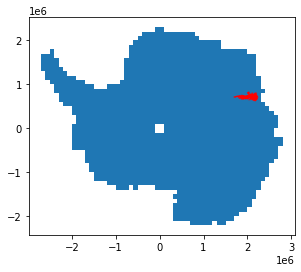

In [43]:
#read in the shapefiles of ice shelf grounding lines
IS = gpd.read_file('IceShelf_Antarctica_v02/IceShelf_Antarctica_v02.shp') 

#select an ice shelf, the Amery Ice Shelf in east Antarctica
Amery = IS[IS.NAME=='Amery']

#read in the REMA tile index
REMA_index = gpd.read_file('REMA_Tile_Index/REMA_Tile_Index_Rel1_1.shp')

fig,axis = plt.subplots()
REMA_index.plot(ax=axis)
Amery.geometry.plot(ax=axis,color='r')

In [44]:
cluster.scale(10)

In [45]:
#bounding box of ice shelf
[minx,miny,maxx,maxy]= Amery.bounds.values.tolist()[0]

bbox = shapely.geometry.asPolygon([[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy],[minx,miny]])

IS_intersection = np.argwhere(REMA_index.overlaps(bbox).tolist())

IS_tiles = REMA_index.tile[IS_intersection.flatten()]

row=np.zeros((len(IS_tiles),1))
col=np.zeros((len(IS_tiles),1))
for i in np.arange(0,len(IS_tiles)):
    [row[i],col[i]] = str.split(IS_tiles.to_list()[i],sep='_')


row = np.int_(row)
col = np.int_(col)

#Load the REMA tiles lazily
uri_fmt = 'https://storage.googleapis.com/pangeo-pgc/8m/{i_idx:02d}_{j_idx:02d}/{i_idx:02d}_{j_idx:02d}_8m_dem_COG_LZW.tif'

chunksize = 8 * 512
rows = []
for i in tqdm(range(row.max()-1, row.min()-1, -1)): #this tile range is Amery Ice Shelf
    cols = []
    for j in range(col.min(),col.max()):
        uri = uri_fmt.format(i_idx=i, j_idx=j)
        try:
            dset = xr.open_rasterio(uri, chunks=chunksize)
            dset_masked = dset.where(dset > 0.0)
            cols.append(dset_masked)
            #print(uri)
        except RasterioIOError:
            pass
    rows.append(cols)

dsets_rows = [xr.concat(row, 'x') for row in rows]
ds = xr.concat(dsets_rows, 'y', )
ds.data

ds_array = ds.squeeze()
ds_array.data

  0%|          | 0/2 [00:00<?, ?it/s]

dask.array<getitem, shape=(25000, 75000), dtype=float32, chunksize=(4096, 4096), chunktype=numpy.ndarray>

In [225]:
sample = ds_array[6*int(ds_array.shape[0]/10):10*int(ds_array.shape[0]/10),11*int(ds_array.shape[1]/20):12*int(ds_array.shape[1]/20)].coarsen(x=5,y=5).mean()

#sample = ds_array[:,11*int(ds_array.shape[1]/20):12*int(ds_array.shape[1]/20)].coarsen(x=5,y=5).mean()


In [228]:
# the four line below come from https://github.com/pangeo-data/pangeo-datastore/issues/116#issuecomment-729928936
gcs = gcsfs.GCSFileSystem()
#url = 'gs://ldeo-glaciology/bedmachine/BedMachineAntarctica_2019-11-05_v01.nc'  
#openfile = gcs.open('antarctic_ice_vel_phase_map_v01.nc', mode='rb') 
#measures = xr.open_dataset('antarctic_ice_vel_phase_map_v01.nc')

with open('ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
gcs = gcsfs.GCSFileSystem(token=token)

mapper = gcs.get_mapper('gs://ldeo-glaciology/MEaSUREs/')
#measures.to_zarr(mapper, mode='w');

measures = xr.open_zarr(mapper,overwrite_encoded_chunks=True)  

measures_dask = measures.chunk(3000)

atangent = dask.array.arctan(measures_dask.VX.data,measures_dask.VY.data)

measures_dask=measures_dask.assign(orientation =(['y','x'], atangent))

measures_dask = measures_dask.rio.write_crs('EPSG:3976')

#measures_clipped = measures_dask.rio.clip_box(minx,miny,maxx,maxy)

In [229]:
[minx,miny,maxx,maxy] = sample.rio.bounds()
measures_clipped = measures_dask.rio.clip_box(minx,miny,maxx,maxy)

In [259]:
def image_destriping(array, vel_array):
    #from Destriping_functions import Lloyd_destripe, Guan_destripe, Rogass_destripe,\
    #Pande_Chhetri_destripe, Pystripe_destripe, RMSE_metric, SSIM_metric, PSNR_metric
    #from Oblique_destriping_functions import striping_angle, grad_image,\
    #super_Gauss_filter, refinement_destriping
    
        
    #Use a Frangi filter to identify any linear features, then create a label array to "blobbify" them 
    labelled = skimage.morphology.label(skimage.filters.frangi(array)>0.00001)
    #Calculate the orientation, find any larger than 500 pixels, return rounded CW angle
    stats = skimage.measure.regionprops_table(labelled, properties={'label', 'area','orientation','major_axis_length'})
    index = np.argwhere(stats['area']>500)
    stripe_orientations = np.round(-(stats['orientation'][index]),2)
    #Identify linear features that are aligned to ice flow +-0.1 rads = 5.7 deg 
    is_flow_stripe = np.abs(stripe_orientations - np.single(np.round(vel_array.mean(),2)))<0.1
    #Find the orientation of artifact stripes
    theta = np.rad2deg(np.median(stripe_orientations[~is_flow_stripe]))
    #Apply a rotated Fourier filter
    Ly_i = np.shape(array)[0]
    Lx_i = np.shape(array)[1]

    N_pad = 2000
    padded_patch = np.zeros((Ly_i+2*N_pad,Lx_i+2*N_pad))
    padded_patch[N_pad:N_pad+Ly_i,N_pad:N_pad+Lx_i] = np.array(array)

    Ly_p = Ly_i + 2*N_pad
    Lx_p = Lx_i + 2*N_pad

    M_forward = cv2.getRotationMatrix2D((Lx_p/2,Ly_p/2),theta,1)
    array_rot = cv2.warpAffine(padded_patch,M_forward,(Lx_p,Ly_p))

    padded_array_rot = np.copy(array_rot)
    padded_array_rot[array_rot==0] = np.mean(array.data[array.data>0])
    M_backward = cv2.getRotationMatrix2D((Lx_p/2,Ly_p/2),-theta,1)
    # refine guess of stripe contribution to image
    Lloyd_destriped = Lloyd_destripe(padded_array_rot,0.5*Lx_p,140)
    destriped_array_ref = refinement_destriping(array_rot,Lloyd_destriped)

    destriped_array_unrot = cv2.warpAffine(destriped_array_ref ,M_backward,\
                                           (Lx_p,Ly_p))

    destriped_image = destriped_array_unrot[N_pad:N_pad+Ly_i,N_pad:N_pad+Lx_i]
    
    #Apply a final gaussian filter
    destriped_image = skimage.filters.gaussian(destriped_image,2)
    destriped_image_xr = xr.DataArray(destriped_image,coords = array.coords)

    return destriped_image_xr

In [260]:
[minx,miny,maxx,maxy] = sample.rio.bounds()
measures_clipped = measures_dask.rio.clip_box(minx,miny,maxx,maxy)
measures_resampled = measures_clipped.interp_like(sample)

chunks_y, chunks_x = sample.chunks
measures_resampled = measures_resampled.orientation.chunk({'x':chunks_x,'y':chunks_y})

In [262]:
cluster.scale(14)

In [263]:
def install():
    import os
    os.system("pip install opencv-python-headless")  # or pip


In [264]:
client.run(install)

{'tls://10.36.251.29:44681': None,
 'tls://10.36.94.226:34939': None,
 'tls://10.36.95.69:41235': None,
 'tls://10.37.17.38:39359': None,
 'tls://10.37.17.39:39175': None,
 'tls://10.37.20.35:36461': None,
 'tls://10.37.20.36:46785': None,
 'tls://10.37.40.17:43375': None,
 'tls://10.37.40.18:36023': None,
 'tls://10.37.50.17:33381': None,
 'tls://10.37.52.2:35965': None,
 'tls://10.37.53.2:44757': None,
 'tls://10.37.54.2:41651': None,
 'tls://10.37.7.26:36261': None}

In [265]:
destriped_sample_ = dask.array.map_blocks(lambda sample, velocity: image_destriping(sample,velocity),sample,measures_resampled.reindex_like(sample), dtype=float)

In [266]:
destriped_sample_ #= destriped_sample_.rechunk({0:-1,1:-1})

dask.array<lambda, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [267]:
destriped_sample = destriped_sample_.compute()

# Filter Testing

### Amery

In [46]:
sample = ds_array[:,1*int(ds_array.shape[1]/20):2*int(ds_array.shape[1]/20)].coarsen(x=5,y=4).mean()

#sample = ds_array[:,11*int(ds_array.shape[1]/20):12*int(ds_array.shape[1]/20)].coarsen(x=5,y=5).mean()


In [47]:
cd 

/home/jovyan


In [48]:
# the four line below come from https://github.com/pangeo-data/pangeo-datastore/issues/116#issuecomment-729928936
gcs = gcsfs.GCSFileSystem()
#url = 'gs://ldeo-glaciology/bedmachine/BedMachineAntarctica_2019-11-05_v01.nc'  
#openfile = gcs.open('antarctic_ice_vel_phase_map_v01.nc', mode='rb') 
#measures = xr.open_dataset('antarctic_ice_vel_phase_map_v01.nc')

with open('ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
gcs = gcsfs.GCSFileSystem(token=token)

mapper = gcs.get_mapper('gs://ldeo-glaciology/MEaSUREs/')
#measures.to_zarr(mapper, mode='w');

measures = xr.open_zarr(mapper,overwrite_encoded_chunks=True)  

measures_dask = measures.chunk(3000)

atangent = dask.array.arctan(measures_dask.VX.data,measures_dask.VY.data)

measures_dask=measures_dask.assign(orientation =(['y','x'], atangent))

measures_dask = measures_dask.rio.write_crs('EPSG:3976')

#measures_clipped = measures_dask.rio.clip_box(minx,miny,maxx,maxy)

In [49]:
[minx,miny,maxx,maxy] = sample.rio.bounds()
measures_clipped = measures_dask.rio.clip_box(minx,miny,maxx,maxy)
measures_resampled = measures_clipped.interp_like(sample)

chunks_y, chunks_x = sample.chunks
measures_resampled = measures_resampled.orientation.chunk({'x':chunks_x,'y':chunks_y})

In [75]:
def image_destriping(array, vel_array):
    #from Destriping_functions import Lloyd_destripe, Guan_destripe, Rogass_destripe,\
    #Pande_Chhetri_destripe, Pystripe_destripe, RMSE_metric, SSIM_metric, PSNR_metric
    #from Oblique_destriping_functions import striping_angle, grad_image,\
    #super_Gauss_filter, refinement_destriping
    
        
    #Use a Frangi filter to identify any linear features, then create a label array to "blobbify" them 
    labelled = skimage.morphology.label(skimage.filters.frangi(array)>0.00001)
    #Calculate the orientation, find any larger than 500 pixels, return rounded CW angle
    stats = skimage.measure.regionprops_table(labelled, properties={'label', 'area','orientation','major_axis_length'})
    index = np.argwhere(stats['area']>500)
    stripe_orientations = np.round(-(stats['orientation'][index]),2)
    #Identify linear features that are aligned to ice flow +-0.1 rads = 5.7 deg 
    is_flow_stripe = np.abs(stripe_orientations - np.single(np.round(vel_array.mean(),2)))<0.1
    #Find the orientation of artifact stripes
    theta = np.rad2deg(np.median(stripe_orientations[~is_flow_stripe]))
    #Apply a rotated Fourier filter
    Ly_i = np.shape(array)[0]
    Lx_i = np.shape(array)[1]
    
    N_pad = 2000
    padded_patch = np.zeros((Ly_i+2*N_pad,Lx_i+2*N_pad))
    padded_patch[N_pad:N_pad+Ly_i,N_pad:N_pad+Lx_i] = np.array(array)
    

    Ly_p = Ly_i + 2*N_pad
    Lx_p = Lx_i + 2*N_pad

    M_forward = cv2.getRotationMatrix2D((Lx_p/2,Ly_p/2),theta,1)
    array_rot = cv2.warpAffine(padded_patch,M_forward,(Lx_p,Ly_p))

    padded_array_rot = np.copy(array_rot)
    padded_array_rot[array_rot==0] = np.mean(array.data[array.data>0])
    M_backward = cv2.getRotationMatrix2D((Lx_p/2,Ly_p/2),-theta,1)
    # refine guess of stripe contribution to image
    Lloyd_destriped = Lloyd_destripe(padded_array_rot,0.5*Lx_p,140)
    destriped_array_ref = refinement_destriping(array_rot,Lloyd_destriped)

    destriped_array_unrot = cv2.warpAffine(destriped_array_ref ,M_backward,\
                                           (Lx_p,Ly_p))

    destriped_image = destriped_array_unrot[N_pad:N_pad+Ly_i,N_pad:N_pad+Lx_i]
    
    #Apply a final gaussian filter
    destriped_image = skimage.filters.gaussian(destriped_image,2)
    destriped_image_xr = xr.DataArray(destriped_image,coords = array.coords)

    return destriped_image_xr

In [51]:
cluster.scale(15)

In [52]:
sample

<xarray.DataArray (y: 6250, x: 750)>
dask.array<mean_agg-aggregate, shape=(6250, 750), dtype=float32, chunksize=(1024, 681), chunktype=numpy.ndarray>
Coordinates:
    band     int64 1
  * y        (y) float64 8e+05 8e+05 7.999e+05 ... 6.001e+05 6e+05 6e+05
  * x        (x) float64 1.63e+06 1.63e+06 1.63e+06 ... 1.66e+06 1.66e+06

In [57]:
def install():
    import os
    os.system("pip install opencv-python-headless")  # or pip


In [92]:
client.run(install)

{'tls://10.36.94.234:39059': None,
 'tls://10.37.50.28:44279': None,
 'tls://10.37.7.34:39249': None,
 'tls://10.37.83.2:33325': None,
 'tls://10.37.84.2:34743': None,
 'tls://10.37.85.2:38249': None,
 'tls://10.37.86.2:36575': None,
 'tls://10.37.87.2:45737': None,
 'tls://10.37.88.2:46157': None,
 'tls://10.37.89.2:43231': None,
 'tls://10.37.90.2:41443': None,
 'tls://10.37.91.2:34737': None,
 'tls://10.37.92.2:33543': None,
 'tls://10.37.93.2:34837': None,
 'tls://10.37.95.2:43147': None}

In [97]:
destriped_sample_ = dask.array.map_blocks(lambda sample, velocity: image_destriping(sample,velocity),sample,measures_resampled.reindex_like(sample), dtype=float)

In [98]:
destriped_sample_ 

dask.array<lambda, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [99]:
destriped_sample = destriped_sample_.compute()

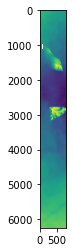

In [100]:
plt.imshow(destriped_sample)

In [101]:
destriped_xr = sample
destriped_xr.data = destriped_sample

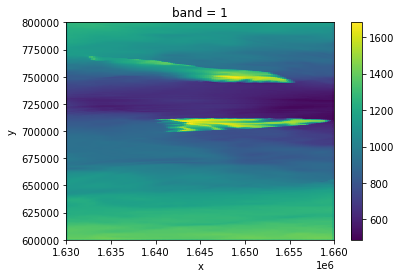

In [102]:
destriped_xr.coarsen(x=5,y=5).mean().plot()

## Roi Baudouin 

In [105]:
cd REMAWaterRouting/Functions/

/home/jovyan/REMAWaterRouting/Functions


<AxesSubplot:>

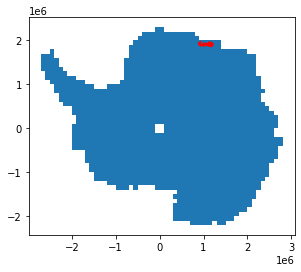

In [111]:

#select an ice shelf, the Amery Ice Shelf in east Antarctica
RoiBaudouin = IS[IS.NAME=='Baudouin']

#read in the REMA tile index
REMA_index = gpd.read_file('REMA_Tile_Index/REMA_Tile_Index_Rel1_1.shp')

fig,axis = plt.subplots()
REMA_index.plot(ax=axis)
RoiBaudouin.geometry.plot(ax=axis,color='r')

In [110]:
cluster.scale(10)

In [112]:
#bounding box of ice shelf
[minx,miny,maxx,maxy]= RoiBaudouin.bounds.values.tolist()[0]

bbox = shapely.geometry.asPolygon([[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy],[minx,miny]])

IS_intersection = np.argwhere(REMA_index.overlaps(bbox).tolist())

IS_tiles = REMA_index.tile[IS_intersection.flatten()]

row=np.zeros((len(IS_tiles),1))
col=np.zeros((len(IS_tiles),1))
for i in np.arange(0,len(IS_tiles)):
    [row[i],col[i]] = str.split(IS_tiles.to_list()[i],sep='_')


row = np.int_(row)
col = np.int_(col)

#Load the REMA tiles lazily
uri_fmt = 'https://storage.googleapis.com/pangeo-pgc/8m/{i_idx:02d}_{j_idx:02d}/{i_idx:02d}_{j_idx:02d}_8m_dem_COG_LZW.tif'

chunksize = 8 * 512
rows = []
for i in tqdm(range(row.max()-1, row.min()-1, -1)): #this tile range is Amery Ice Shelf
    cols = []
    for j in range(col.min(),col.max()):
        uri = uri_fmt.format(i_idx=i, j_idx=j)
        try:
            dset = xr.open_rasterio(uri, chunks=chunksize)
            dset_masked = dset.where(dset > 0.0)
            cols.append(dset_masked)
            #print(uri)
        except RasterioIOError:
            pass
    rows.append(cols)

dsets_rows = [xr.concat(row, 'x') for row in rows]
ds = xr.concat(dsets_rows, 'y', )
ds.data

ds_array = ds.squeeze()
ds_array.data

  0%|          | 0/1 [00:00<?, ?it/s]

dask.array<getitem, shape=(12500, 50000), dtype=float32, chunksize=(4096, 4096), chunktype=numpy.ndarray>

In [146]:
sample = ds_array[:,8*int(ds_array.shape[1]/10):10*int(ds_array.shape[1]/10)].coarsen(x=4,y=5).mean()


In [147]:
cd

/home/jovyan


In [148]:
# the four line below come from https://github.com/pangeo-data/pangeo-datastore/issues/116#issuecomment-729928936
gcs = gcsfs.GCSFileSystem()
#url = 'gs://ldeo-glaciology/bedmachine/BedMachineAntarctica_2019-11-05_v01.nc'  
#openfile = gcs.open('antarctic_ice_vel_phase_map_v01.nc', mode='rb') 
#measures = xr.open_dataset('antarctic_ice_vel_phase_map_v01.nc')

with open('ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
gcs = gcsfs.GCSFileSystem(token=token)

mapper = gcs.get_mapper('gs://ldeo-glaciology/MEaSUREs/')
#measures.to_zarr(mapper, mode='w');

measures = xr.open_zarr(mapper,overwrite_encoded_chunks=True)  

measures_dask = measures.chunk(3000)

atangent = dask.array.arctan(measures_dask.VX.data,measures_dask.VY.data)

measures_dask=measures_dask.assign(orientation =(['y','x'], atangent))

measures_dask = measures_dask.rio.write_crs('EPSG:3976')

#measures_clipped = measures_dask.rio.clip_box(minx,miny,maxx,maxy)

In [149]:
[minx,miny,maxx,maxy] = sample.rio.bounds()
measures_clipped = measures_dask.rio.clip_box(minx,miny,maxx,maxy)
measures_resampled = measures_clipped.interp_like(sample)

chunks_y, chunks_x = sample.chunks
measures_resampled = measures_resampled.orientation.chunk({'x':chunks_x,'y':chunks_y})

In [150]:
cluster.scale(16)

In [151]:
def install():
    import os
    os.system("pip install opencv-python-headless")  # or pip


In [153]:
client.run(install)

{'tls://10.36.94.234:40865': None,
 'tls://10.37.50.28:44279': None,
 'tls://10.37.7.34:43673': None,
 'tls://10.37.85.2:44677': None,
 'tls://10.37.86.2:40227': None,
 'tls://10.37.87.2:33129': None,
 'tls://10.37.88.2:37587': None,
 'tls://10.37.92.2:33543': None,
 'tls://10.37.93.3:38423': None,
 'tls://10.37.95.3:35481': None,
 'tls://10.37.97.5:46103': None,
 'tls://10.37.99.3:34409': None}

In [154]:
destriped_sample_ = dask.array.map_blocks(lambda sample, velocity: image_destriping(sample,velocity),sample,measures_resampled.reindex_like(sample), dtype=float)

In [155]:
destriped_sample_ #= destriped_sample_.rechunk({0:-1,1:-1})

dask.array<lambda, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [156]:
destriped_sample = destriped_sample_.compute()

In [157]:
destriped_xr = sample
destriped_xr.data = destriped_sample

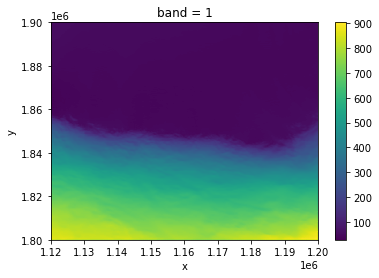

In [158]:
destriped_xr.coarsen(x=5,y=5).mean().plot()

In [172]:
destriped_xr = destriped_xr.chunk(1000)


In [174]:
cellsize = 32*40

dem_fixed = destriped_xr.data.map_blocks(remove_small_holes,dtype=float).persist()

nhood = np.ones((3,3))
identified_flats = dem_fixed.map_blocks(identifyflats, dtype=float)


flats = identified_flats.persist()

identified_sills = dask.array.map_blocks(lambda dem,flats: identifysills(dem,flats), dem_fixed, identified_flats, dtype=float)#identifysills(sample_and_flats) #still would like to do this chunkwise

sills = identified_sills.persist()

identified_interbasins = dem_fixed.map_blocks(lambda dem: identifyinteriorbasins(dem), dtype=float)

interiorbasins = identified_interbasins.persist()

FlowObj_dask = lambda dem,flats,sills,interiorbasins: drainagebasins(dem,flats,sills,interiorbasins,cellsize)

#flats  = flats
FlowObj_values = dask.array.map_blocks(FlowObj_dask,dem_fixed,flats,sills,interiorbasins, dtype=float)

#FlowObj_values=FlowObj_values.rechunk(5000)

FlowObj_values = FlowObj_values.rechunk(1000)
FlowObj_values

dask.array<lambda, shape=(2500, 2500), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [175]:
cluster.scale(18)

In [176]:
DB = FlowObj_values.compute()

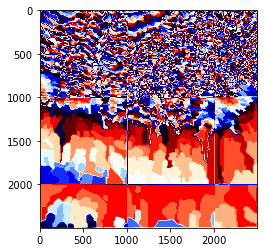

In [183]:
plt.imshow(DB,cmap='flag')

# Filter Development 

In [17]:
test  = sample[6000:7000]#dask.array.rechunk(sample[6000:7000],{0: -1, 1: -1})
stripes = (test[:400,1000:1250])

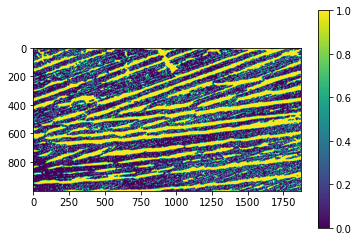

In [86]:
plt.imshow(skimage.filters.frangi(test)>0.00001)
plt.colorbar()

In [87]:
test_detrended = scipy.signal.detrend(test)
trend = test-test_detrended

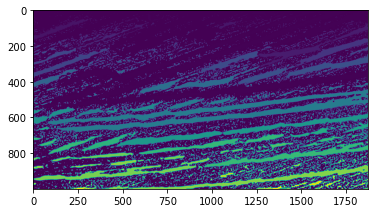

In [88]:
labelled = skimage.morphology.label(skimage.filters.frangi(test)>0.00001)
plt.imshow(labelled)

In [89]:
stats = skimage.measure.regionprops_table(labelled, properties={'label', 'area','orientation','major_axis_length'})


In [106]:
[n,bins] = np.histogram(np.rad2deg(stats['orientation']),100)


(70.0, 90.0)

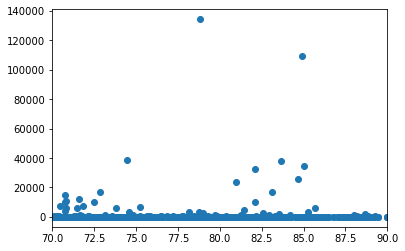

In [144]:
plt.scatter(-np.rad2deg(stats['orientation']),stats['area'])
plt.xlim([70,90])

(array([ 2.,  1.,  0.,  0.,  1.,  0.,  0.,  0., 16., 48.]),
 array([-1.49868617, -1.19409841, -0.88951064, -0.58492288, -0.28033511,
         0.02425266,  0.32884042,  0.63342819,  0.93801595,  1.24260372,
         1.54719149]),
 <BarContainer object of 10 artists>)

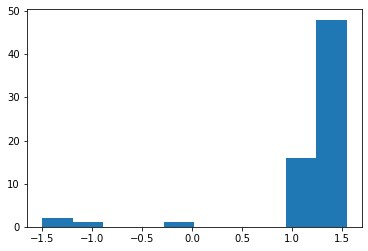

In [153]:
index = np.argwhere(stats['area']>500)
plt.hist(-(stats['orientation'][index]))

In [187]:
stripe_orientations = np.round(-(stats['orientation'][index]),2)

is_flow_stripe = np.abs(stripe_orientations - np.single(np.round(measures_clipped.orientation.mean(),2)))<0.1

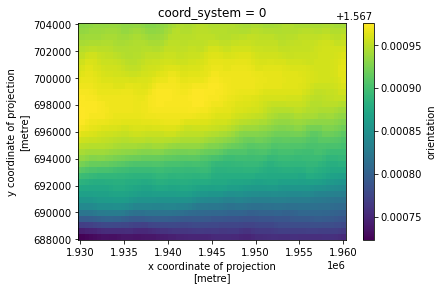

In [143]:
measures_clipped.orientation.plot()
#measures_clipped.VX.plot()


In [92]:
test.data.compute()

array([[ 99.868744,  99.64685 ,  99.39071 , ...,  98.03174 ,  98.0852  ,
         98.08661 ],
       [ 99.66303 ,  99.35957 ,  99.096344, ...,  98.1199  ,  98.16124 ,
         98.12656 ],
       [ 99.453865,  99.133484,  98.91978 , ...,  98.252884,  98.26871 ,
         98.17395 ],
       ...,
       [105.560196, 105.63832 , 105.62535 , ..., 102.43077 , 102.421196,
        102.40166 ],
       [105.67101 , 105.717606, 105.653946, ..., 102.38653 , 102.29901 ,
        102.207634],
       [105.760956, 105.81558 , 105.73744 , ..., 102.375046, 102.26028 ,
        102.14364 ]], dtype=float32)

In [88]:
stripes_detrended = scipy.signal.detrend(test)
trend = test-stripes_detrended
stripes_sharpened = skimage.filters.unsharp_mask(stripes_detrended,5,0)

In [89]:
theta = np.rad2deg(np.median(stripe_orientations[~is_flow_stripe]))#-np.rad2deg(stats['orientation'][np.argmax(stats['area'])])#striping_angle(skimage.filters.frangi(stripes)>0.00001)
theta

NameError: name 'stripe_orientations' is not defined

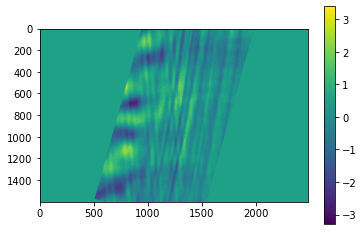

In [90]:
striped_image = stripes_detrended

Ly_i,Lx_i = np.shape(striped_image)

N_pad = 300
padded_patch = np.zeros((Ly_i+2*N_pad,Lx_i+2*N_pad))
padded_patch[N_pad:N_pad+Ly_i,N_pad:N_pad+Lx_i] = striped_image

Ly_p = Ly_i + 2*N_pad
Lx_p = Lx_i + 2*N_pad

M_forward = cv2.getRotationMatrix2D((Lx_p/2,Ly_p/2),theta,1)
array_rot = cv2.warpAffine(padded_patch,M_forward,(Lx_p,Ly_p))

padded_array_rot = np.copy(array_rot)
padded_array_rot[array_rot==0] = np.mean(striped_image[striped_image>0])
    
plt.imshow(padded_array_rot)
plt.colorbar()

In [213]:
## Lloyd Destriping

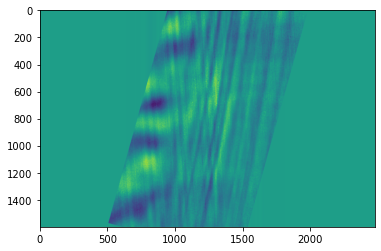

In [214]:

Lloyd_destriped = Lloyd_destripe(padded_array_rot,0.5*Lx_p,140)
plt.imshow(Lloyd_destriped)

In [215]:
M_backward = cv2.getRotationMatrix2D((Lx_p/2,Ly_p/2),-theta,1)
# refine guess of stripe contribution to image
destriped_array_ref = refinement_destriping(array_rot,Lloyd_destriped)
    
destriped_array_unrot = cv2.warpAffine(destriped_array_ref ,M_backward,\
                                       (Lx_p,Ly_p))

destriped_image = destriped_array_unrot[N_pad:N_pad+Ly_i,N_pad:N_pad+Lx_i]

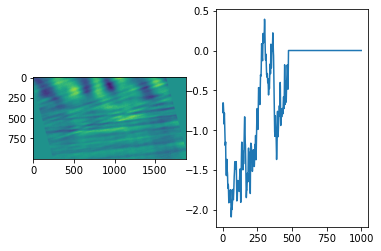

In [216]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(destriped_image)
ax[1].plot(destriped_image[:,100])

In [217]:
destriped_image = skimage.filters.gaussian(destriped_image+trend,2)
flats= identifyflats(destriped_image)
sills = identifysills(destriped_image,flats)
interiorbasins = identifyinteriorbasins(destriped_image)

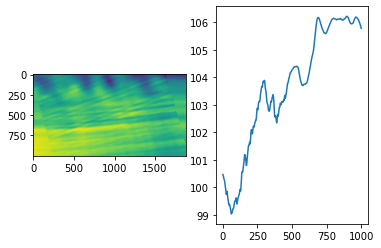

In [218]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(destriped_image)
ax[1].plot(destriped_image[:,100])

In [219]:
DB_destriped= drainagebasins(destriped_image,flats,sills,interiorbasins,cellsize=16**2)

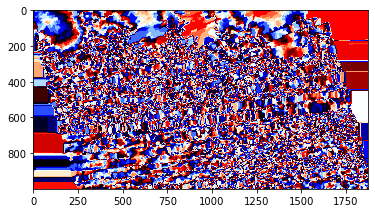

In [221]:
plt.imshow(DB_destriped,cmap='flag')

In [222]:
## Super Gauss filter

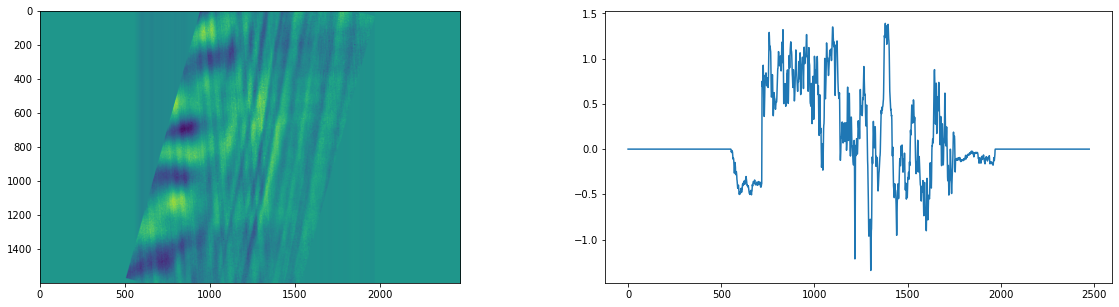

In [224]:
# use standard values for filter parameters
destriped_array_rot = super_Gauss_filter(padded_array_rot,Lx_p*0.1,2000,5) #changed width from LX*0.485,100,0

# refine guess of stripe contribution to image
destriped_array_ref = refinement_destriping(array_rot,destriped_array_rot)
fig, ax = plt.subplots(ncols=2, figsize=(20,5))
ax[0].imshow(destriped_array_ref)
ax[1].plot(destriped_array_ref[800,:])

In [225]:
destriped_array_unrot = cv2.warpAffine(destriped_array_ref ,M_backward,\
                                       (Lx_p,Ly_p))

destriped_image = destriped_array_unrot[N_pad:N_pad+Ly_i,N_pad:N_pad+Lx_i]

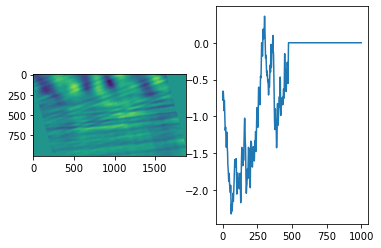

In [226]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(destriped_image)
ax[1].plot(destriped_image[:,100])

In [227]:
destriped_image = skimage.filters.gaussian(destriped_image+trend,4)
flats= identifyflats(destriped_image)
sills = identifysills(destriped_image,flats)
interiorbasins = identifyinteriorbasins(destriped_image)

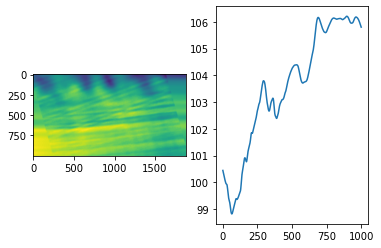

In [228]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(destriped_image)
ax[1].plot(destriped_image[:,100])

In [229]:
DB_destriped= drainagebasins(destriped_image,flats,sills,interiorbasins,cellsize=16**2)

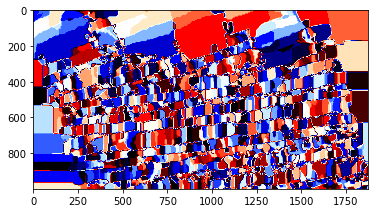

In [230]:
plt.imshow(DB_destriped,cmap='flag')

In [48]:
#https://dsrg-ict.research.um.edu.mt/gianluca/destriping-of-remote-sensing-images/blob/master/Oblique%20stripes/Destriping%20Generic%20Image/Oblique_destriping_functions.py

import numpy as np
import matplotlib.pyplot as plt
import cv2
from Oblique_destriping_functions import striping_angle, grad_image,\
super_Gauss_filter, refinement_destriping

In [49]:
if np.amax(grad_image(striped_image/np.mean(striped_image)))<0.006:
    destriped_image = super_Gauss_filter(striped_image,0.49*Lx_i,110,theta)
    
else:
    N_pad = 300
    padded_patch = np.zeros((Ly_i+2*N_pad,Lx_i+2*N_pad))
    padded_patch[N_pad:N_pad+Ly_i,N_pad:N_pad+Lx_i] = striped_image
    
    Ly_p = Ly_i + 2*N_pad
    Lx_p = Lx_i + 2*N_pad
    
    M_forward = cv2.getRotationMatrix2D((Lx_p/2,Ly_p/2),theta,1)
    array_rot = cv2.warpAffine(padded_patch,M_forward,(Lx_p,Ly_p))
    
    padded_array_rot = np.copy(array_rot)
    padded_array_rot[array_rot==0] = np.mean(striped_image[striped_image>0])
    
    # use standard values for filter parameters
    destriped_array_rot = super_Gauss_filter(padded_array_rot,Lx_p*0.485,100,0)
    
    # refine guess of stripe contribution to image
    destriped_array_ref = refinement_destriping(array_rot,destriped_array_rot)
    
    M_backward = cv2.getRotationMatrix2D((Lx_p/2,Ly_p/2),-theta,1)
    destriped_array_unrot = cv2.warpAffine(destriped_array_ref ,M_backward,\
                                           (Lx_p,Ly_p))
    destriped_image = destriped_array_unrot[N_pad:N_pad+Ly_i,N_pad:N_pad+Lx_i]
    

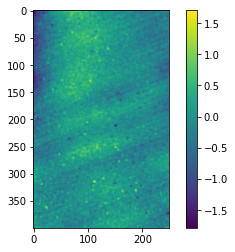

In [50]:
plt.imshow(destriped_image)
plt.colorbar()

In [54]:

destriped_image = skimage.filters.gaussian(destriped_image+trend,4)
flats= identifyflats(destriped_image)
sills = identifysills(destriped_image,flats)
interiorbasins = identifyinteriorbasins(destriped_image)

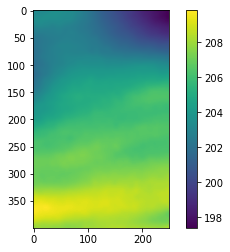

In [57]:
plt.imshow(destriped_image)
plt.colorbar()

In [55]:
DB_destriped= drainagebasins(destriped_image,flats,sills,interiorbasins,cellsize=8**2)

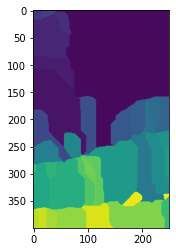

In [56]:
plt.imshow(DB_destriped)

In [64]:
## Spergel Method

In [100]:
im_new = super_Gauss_filter(stripes_detrended,120,100,theta)

Text(0.5, 1.0, 'Reconstructed Image')

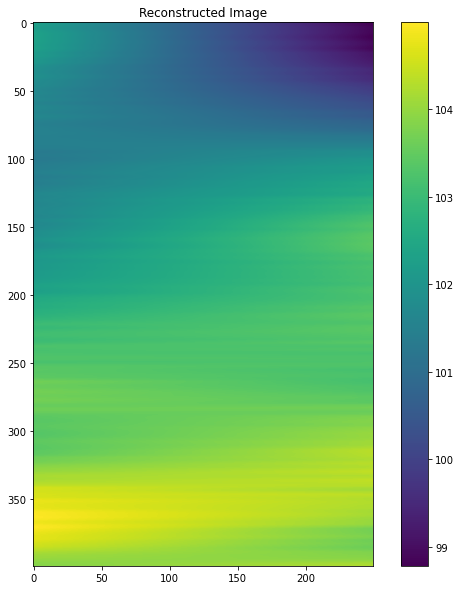

In [102]:
plt.figure(figsize=(10,10))
plt.imshow(im_new+trend)
#plt.imshow(im_new)
plt.colorbar()
plt.title('Reconstructed Image')